# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [17]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets.mini_imagenet import MiniImageNet, Split
from datasets.utils import extract_archive

# Dataset Sandbox

In [43]:
from torchvision.transforms import Compose, ToTensor, Resize, Lambda
from torchvision.transforms.functional import InterpolationMode

datadir = "../../data/mini-imagenet"
im_size = 28

transforms = Compose(
    [
        Resize(im_size, InterpolationMode.LANCZOS),
        ToTensor(),
        Lambda(lambda x: x.unsqueeze(0)),  # used to add batch dimension
    ]
)
t_transforms = Lambda(lambda x: torch.tensor(x).unsqueeze(0))
ds = MiniImageNet(
    root=datadir,
    split=Split.TRAIN,
    transform=transforms,
    target_transform=t_transforms,
    greyscale=True,
    download=True,
)

Computing MD5: /Users/ntraft/Development/data/mini-imagenet/train.tar
MD5 matches: /Users/ntraft/Development/data/mini-imagenet/train.tar
/Users/ntraft/Development/data/mini-imagenet/processed_images/train already exists.


Training Set statistics:
64 classes
38400 examples


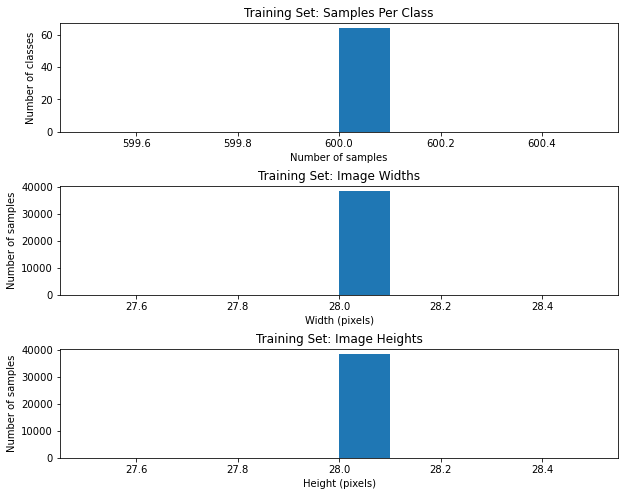

In [74]:
from collections import defaultdict


def show_image_classification_dataset_stats(name, dataset):
    """
    Show statistics for an image classification dataset.
    
    Args:
        name (str): Name of the dataset, like "Training" or "Validation".
        dataset (Dataset): A PyTorch dataset object.
    """
    title = name + " Set"
    print(f"Collecting {title} statistics...", end=" ", flush=True)
    total_size = 0
    class_sizes = []
    widths = []
    heights = []
    class_map = defaultdict(int)
    for img, label in dataset:
        class_map[int(label)] += 1
        if isinstance(img, PIL.Image.Image):
            widths.append(img.width)
            heights.append(img.height)
        else:
            widths.append(img.size()[-1])
            heights.append(img.size()[-2])
    class_sizes = list(class_map.values())
    print("done.")

    print(title, "statistics:")
    print(len(class_map), "classes")
    print(len(dataset), "examples")

    fig, (sax, wax, hax) = plt.subplots(3, figsize=(10, 8), gridspec_kw={"hspace": 0.5})
    sax.hist(class_sizes)
    sax.set_xlabel("Number of samples")
    sax.set_ylabel("Number of classes")
    sax.set_title(f"{title}: Samples Per Class")

    wax.hist(widths)
    wax.set_xlabel("Width (pixels)")
    wax.set_ylabel("Number of samples")
    wax.set_title(f"{title}: Image Widths")

    hax.hist(heights)
    hax.set_xlabel("Height (pixels)")
    hax.set_ylabel("Number of samples")
    hax.set_title(f"{title}: Image Heights")

    
show_image_classification_dataset_stats(str(ds.split), ds)

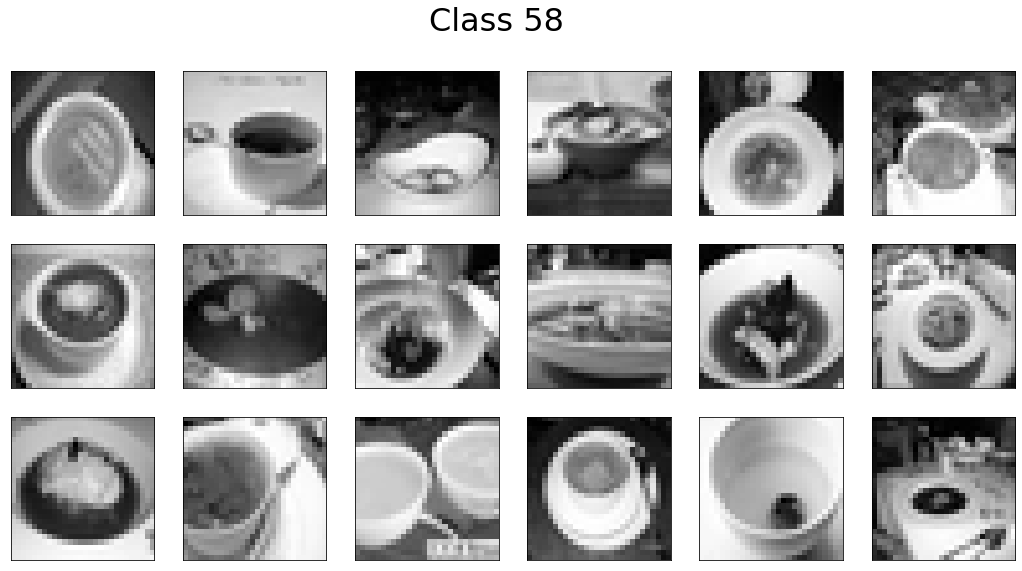

In [81]:
# Randomly sample from a random class and display the samples.
# NOTE: Assumes a dataset of type ClassIndexedDataset.
rows = 3
cols = 6
rng = np.random.default_rng()
indices = rng.choice(rng.choice(ds.class_index), size=rows*cols, replace=False)
samples = [ds[i] for i in indices]

fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
fig.suptitle(f"Class {int(samples[0][1])}", fontsize=32)
for i, (img, _) in enumerate(samples):
    ax = axs[i//cols - 1, i%cols]
    if not isinstance(img, PIL.Image.Image):  # if not image, then must be array-like
        img = img.squeeze()
    # cmap will be ignored if data is RGB(A) format, so this is compatible with both single- and multi-channel images.
    ax.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Torch Sandbox

In [30]:
from model import ConvBlock

in_channels = 1
out_channels = 256
conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3)

batch = torch.randn(20, in_channels, 28, 28)
out = conv2(conv1(batch))
print(out.size())

print(F.max_pool2d(batch, kernel_size=2, stride=2).size())
print(F.max_pool2d(out, kernel_size=2, stride=2).size())
print(torch.flatten(out, start_dim=1).size())
print(np.prod(out.size()[1:]))
print()

torch.Size([20, 256, 24, 24])
torch.Size([20, 1, 14, 14])
torch.Size([20, 256, 12, 12])
torch.Size([20, 147456])
147456
49152.0


In [63]:
a = torch.randn(1, 1, 28, 28)
a.squeeze().size()

torch.Size([28, 28])

# Python Sandbox

In [49]:
list([1, 2, 3])

[1, 2, 3]